# The k-NN algorithm

Note that the procedure is not limited to regression tasks. We can also use it for classification where the target value is a category. For instance, we could have price labels associated with each house.

### Distance metrics

The k-NN algorithm is very generic because we can define different distance metrics depending on the type of features. For instance, we can use

- the Euclidean distance $L2$
- the Taxicab distance $L1$ (also called Manhattan distance)
- the Levenshtein distance for texts

The 
$L
2$
 distance between two points is the "ordinary" straight line distance, whereas the 
$L
1$
 distance corresponds to the shortest path between them with only horizontal and vertical steps.

We can also define our own problem-specific metrics. For instance, we can use the Levenshtein distance to measure how far two texts are from each other. In short, it corresponds to the minimum number of "small alterations" to get from one text to the other. For instance

Note that we can also define **custom decision functions**. For instance, we can take the distance to each neighbor into consideration and make **closer ones have a bigger weight** on the average or the majority vote.

### Summary 

To summarize, k-NN is an intuitive algorithm that works for both **regression and classification tasks**. It uses a distance metric and a decision function that can be adapted to the problem. Unlike linear regressions, it doesn't learn a vector 
⃗
$w$
 of parameters but directly uses the data to compute predictions.

In practice, k-NN is a good baseline that gives reasonable performance in most cases. In the next unit, we will visualize its decision boundary and see the intuition behind the k parameter.

# Decision boundaries

In the previous unit, we saw the basic idea behind k-NN. In particular, we saw that it applies to both regression and classification problems but also to different types of features using the appropriate distance metric.

In this unit, we will visualize its **decision boundary** on the UCI wine data set and see the intuition behind the k parameter.

### Wine classification

The goal is to classify wine samples based on thirteen chemical features such as alcohol, acidity, magnesium, phenols and so on. The wines come from the same region in Italy but from three different cultivars that we label 1, 2 and 3.

To make the problem simpler, we can **reduce the number of features using a technique called principal component analysis (PCA)**. The idea is to analyze our data and compute what we call the principal components. We will learn about this technique later in this course, but it's important to understand that we can reduce the number of features while keeping most of the information. For our example, we apply PCA to the original data and extract two features.

Here is a plot of the different wines (data points) in this 2-dimensional reduced input space.

In [1]:
from IPython.display import Image

In [2]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3835/wine-knn-1.png')

We can see that each type of wine occupies a different region on the plot. In other words, there is a clear separation between them which means that we should be able to classify new wines without making too many mistakes. The idea is to assign categories to each region of the feature space and use this partitioning to classify new wine samples. We call the boundaries of these regions decision boundaries.

Let's plot the decision boundaries of the k-NN classifier for 
k
=
1

We can see that there are three distinct regions and three small orange "islands" around data points of type 2 in the regions of classes 1 and 3. We can see them as corner cases rules of the classifier. This is a consequence of the small k value. In our case, 
k
=
1
 and we match each point on the plot with its nearest wine sample from our data set. Hence, these orange islands indicate locations that are closer to an orange point than to a green or blue one.

In [3]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/3837/wine-knn30.png')

The orange islands disappear because we are now doing a majority vote among the 30 nearest data points. In other words, there is an **averaging effect33 which results in smoother decision boundaries. For instance, the boundary between type 1 and type 2 at 
(
0.8
,
0.3
)
 is now a straight line and two blue points are in the orange region.

In other words, k controls how flexible our k-NN model is. In that sense, this hyperparameter is **similar to the regularization strength in ridge regression**. Both control the under-/overfitting balance.

# Baseline for classification

Let's now go through a concrete classification task and **see how to solve it step-by-step using Numpy and Scikit-learn**. In this unit, we will start by setting a baseline, and in the next ones, we will try with a k-NN classifier.

### Heart disease diagnosis data set

We will work on the heart disease diagnosis data set from the UCI machine learning repository. The goal is to diagnose the presence (or absence) of a heart disease based on a set of observations for each patient

1. age - the age of the patient
2. trestbps - the resting blood pressure in mm Hg
3. chol - the amount of cholesterol in mg/dl
4. thalach - maximum heart rate during the tests
5. oldpeak - another measure obtained using an electrocardiogram
6. ca - the number of major vessels colored by fluoroscopy

Our goal is to use these features to predict a target disease variable.



In [4]:
import pandas as pd

# Load data
data_df = pd.read_csv('heart-numerical.csv')

# First five rows
data_df.head()

,age,trestbps,chol,thalach,oldpeak,ca,disease
0,63,145,233,150,2.3,0,absence
1,67,160,286,108,1.5,3,presence
2,67,120,229,129,2.6,2,presence
3,37,130,250,187,3.5,0,absence
4,41,130,204,172,1.4,0,absence


In [5]:
import numpy as np

# Create X/y arrays
X = data_df.drop('disease', axis=1).values
y = data_df.disease.values

print('X:', X.shape, X.dtype) # (303, 6) float64
print('y:', y.shape, y.dtype) # dtype object

# Print labels
labels = np.unique(y)
print('Labels:', labels) # ['absence' 'presence']

X: (303, 6) float64
y: (303,) object
Labels: ['absence' 'presence']


In [6]:
from sklearn.model_selection import train_test_split

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('Train set:', X_tr.shape, y_tr.shape)
# Prints: (212, 6) (212,)

print('Test set:', X_te.shape, y_te.shape)
# Prints: (91, 6) (91,)

Train set: (212, 6) (212,)
Test set: (91, 6) (91,)


The code to load and split the data set is **similar to what we saw for regression tasks. The only difference is that the output vector y contains categorical values** instead of continuous ones.

Before fitting k-NN, let's first define the baseline.

### The "most frequent" baseline

We saw that it makes sense to predict the mean or median of the target variable for regression tasks. In the classification case, we can predict the most frequent category.

In our example, there are only two categories and the most frequent one is 'absence'

In [7]:
# Count the number of entries labeled with 'absence'
n_absence = np.sum(y_tr == 'absence')

print('Total absence:', n_absence)
# Prints: 117

Total absence: 117


We use Numpy $sum()$ on an array of boolean values to count the number of True entries. We get that 117 of the 212 patients from the training set are labeled with 'absence'. In other words, the proportion of patients not diagnosed with the heart disease is around 55%.

In [8]:
# Probability of 'absence'
p_absence = n_absence / len(y_tr)

print('Probability of absence: {:.2f}'.format(p_absence))
# Prints: 0.55

Probability of absence: 0.55


In [9]:
# On the test set
p_absence_te = np.sum(y_te == 'absence') / len(y_te)

print('Probability of absence: {:.2f}'.format(p_absence_te))
# Prints: 0.52

Probability of absence: 0.52


The number 0.52 is **the accuracy** of the baseline model. It corresponds to the proportion of data points from the test set that the model classified correctly. In classification tasks, this is often what we want to maximize. Similarly, **the error rate** is the proportion of data points misclassified. In our case, the error rate of the "most frequent" baseline is 0.48.

In general, the accuracy of the "most frequent" baseline should be equal to the percentage of samples in the most frequent category. Hence, it's only better than random guessing when the distribution of the target variable is not uniform. In our case, the data set contains approximately the same number of patients labeled with absence and presence. Hence, it's accuracy is very close to 50% which corresponds to random guessing for two classes.

### Multiple classes
The code from above doesn't scale well to target variables with many categories because we have to count the number of entries in each one manually. One solution is to use value_counts(list) from Pandas which groups the entries by values and counts the number of entries in each group.

In [10]:
# Compute distribution using Pandas
pd.Series(y_tr).value_counts() / len(y_tr)

absence     0.551887
presence    0.448113
dtype: float64

In [11]:
# Compute distribution using Pandas
pd.Series(y_tr).value_counts(normalize=True)

absence     0.551887
presence    0.448113
dtype: float64

### Scikit-learn DummyClassifier
Scikit-learn provides a DummyClassifier() to compute baselines for classification tasks. We can set its strategy parameter to 'most_frequent' to get the baseline from above

In [12]:
from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

In [13]:
# Fit it
dummy.fit(None, y_tr)

# Compute test accuracy
accuracy = dummy.score(None, y_te)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.52


One important difference with regression: Scikit-learn classifiers return the accuracy instead of the 
$R^2$
 coefficient.

### Confusion matrix


In [14]:
# "Most-frequent" predictions
y_pred_absence = dummy.predict(X_te)
print('Predicted:', y_pred_absence[:5], '..') 
print('True labels:', y_te[:5], '..')

Predicted: ['absence' 'absence' 'absence' 'absence' 'absence'] ..
True labels: ['absence' 'absence' 'presence' 'absence' 'presence'] ..


In [15]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
matrix = confusion_matrix(y_true=y_te, y_pred=y_pred_absence)
print(matrix)

[[47  0]
 [44  0]]


This is simply a frequency table that shows how many times we predicted some class versus how many times it is actually that class or another one i.e. a frequency table of predictions versus true class

In [16]:
# Confusion matrix as a DataFrame
matrix_df = pd.DataFrame(
    matrix, 
    columns=['pred: absence', 'pred: presence'],
    index=['true: absence', 'true: presence']
)
matrix_df

,pred: absence,pred: presence
true: absence,47,0
true: presence,44,0


In our case, we can see that **our "most-frequent" baseline always predicts "absence" ..** which is correct 47 times, and incorrect 44 times.

From this matrix, we can derive two important metrics: **the recall and precision** of our classifier. Those scores are defined in terms of the number of true or false positives/negatives


Intuitively, the precision answers "How many times are we correct when we predict positive?". The formula is simply

precision = tp/(tp+fp)

We can compute it in Scikit-learn using precision_score()

In [17]:
from sklearn.metrics import precision_score

precision_score(y_true=y_te, y_pred=y_pred_absence, pos_label='presence')

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In our case, the precision is not defined since our "most-frequent" baseline never predicts 'presence' ..

However, we can compute it for a "always predicts presence" baseline

In [18]:
# Precision of the "always predicts presence" baseline
y_pred_presence = np.full_like(y_te, fill_value='presence')
precision_score(y_true=y_te, y_pred=y_pred_presence, pos_label='presence')

0.4835164835164835

Intuitively, the recall measures "How many times do we predict positive when it is?". The formula is simply :
recall = tp/(tp+fn)

In [19]:
from sklearn.metrics import recall_score

recall_score(y_true=y_te, y_pred=y_pred_absence, pos_label='presence')

0.0

Our "most-frequent" baseline never predicts 'presence' when the disease is present, so the recall score is 0.0 in our case.

However, we can get a score of 1.0 with the "always predicts presence" baseline!

In [20]:
# Recall of the "always predicts presence" baseline
recall_score(y_true=y_te, y_pred=y_pred_presence, pos_label='presence')

1.0

The F1 score is a way to combine the precision and recall metrics into a single score. The formula is
f1_score = 2 * (precision * recall) / (precision + recall)


In [21]:
from sklearn.metrics import f1_score

f1_score(y_true=y_te, y_pred=y_pred_presence, pos_label='presence')

0.6518518518518518

Note: Scikit-learn also provides a fbeta_score() function which has a "beta" parameter to set the recall/precision balance in the score. You can read more about it in the sklearn.metrics.fbeta_score page.

### Classification report
It's common to print those metrics when analyzing the performance of classifiers. For this reason, Scikit-learn provides a classification_report() function that gives the different scores

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_true=y_te, y_pred=y_pred_presence)
print(report)

              precision    recall  f1-score   support

     absence       0.00      0.00      0.00        47
    presence       0.48      1.00      0.65        44

   micro avg       0.48      0.48      0.48        91
   macro avg       0.24      0.50      0.33        91
weighted avg       0.23      0.48      0.32        91



C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Note: In this table, support corresponds to the number of points in each class. Micro, macro and weighted averages refer to different ways to combine the results when there are multiple classes.

### Summary
In this unit, we saw how to set a baseline for classification tasks using Numpy, Pandas, and Scikit-learn. In the next unit, we will do a quick review about standardization and see how to fit a k-NN classifier using Scikit-learn.

# Standardization and k-NN

In this unit, we will fit k-NN to the heart disease data. But before that, let's first discuss the required preprocessing steps and do a quick refresher about standardization.

### Standardization refresher
In the last course, we saw that we can standardize a set of values by computing z-scores. In short: we subtract the mean 
$μ$
 to each value 
$x$
 and divide the result by the standard deviation 
$σ$
 and obtain scores 
$z$
 that are centered (mean of zero) and rescaled (standard deviation of one)

$z
=
(x
−
μ)
/
σ$

We know that standardization is needed in many situations. For instance, we saw that **gradient descent underperforms or even diverges when features have different scales**, or that it's recommended to **standardize data before applying regularization**. But what about k-NN?

### Standardization and k-NN
First, k-NN doesn't learn parameters from the training set. Its k value is a **hyperparameter set before fitting the algorithm**. Hence, it doesn't use an optimizer like gradient descent. However, we need to be careful about the features scale because it uses a distance metric to find the nearest neighbors. Let's take an example with the human heights and weights data set.

The data contains 25 thousand height and weight measurements from children under 18. Here is a plot of the data

In this example, the weight variable has a much larger scale than height. For this reason, we need to be careful: k-nearest neighbors searches for points with similar values. Since the weight values are more spread out, k-NN will favor points with similar weight values.

To illustrate this issue, here is an image with the 100 nearest points to the average person with weight=127 and height=68

As we can see, k-NN selects points with similar weight values and the orange circle spans most of the data on the y-axis: the height variable has nearly no impact on the nearest neighbors search.

It's important to note that standardizing the data doesn't modify the information content: we can still observe the relationship between height and weight i.e. taller people weigh more.

As you can see, the 100 points from the previous experiment in orange now form an ellipse with the weight variable as the minor axis. This reveals the bias of k-NN toward similar weight values.

### When to apply standardization

In practice, we standardize the input data for two reasons

- Some **optimization algorithms** work better when the features are standardized ex. gradient descent
- Some algorithms are sensitive to the scale of the features because they use a **distance metric** ex. k-NN
- With **regularization** which expects features to be on the same scale

In most cases, it's a good idea to standardize the features when using k-NN to avoid having a model that is biased toward features that have a larger scale.

However we need to remember that by standardizing the data we transform the feature space and in some cases this transformation might produce undesired results. For instance, in the first example that we saw with the house prices from the "K-nearest neighbors" introductory unit, each data point is represented by its location on a longitude/latitude grid. But the data points (the houses) might be more spread out along the longitude or the latitude axis. (Long Beach (NY, USA) or the African state The Gambia are examples of this.) So in this case, we don't want to rescale these two features individually, but with the same scaler. In other scenarios features may be representing different prices or the time intervals measured by different sensors. It depends on the particular context and our judgement whether we think that the relative relationship of these feature values is important and standardising them risks distortion when using k-NN. In any case, it's a good idea to try with and without standardization to see what works best.

### KNeighborsClassifier


In [23]:
import pandas as pd

# Load data
data_df = pd.read_csv('heart-numerical.csv')

# Data summary
data_df.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604,0.663366
std,9.038662,17.599748,51.776918,22.875003,1.161075,0.934375
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000


The features have different scales, so we will add a StandardScaler step in our classification pipeline. But, let's first split the data

In [24]:
from sklearn.model_selection import train_test_split

# Create X/y arrays
X = data_df.drop('disease', axis=1).values
y = data_df.disease.values

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

We can now create a **pipeline object with k-NN**. Scikit-learn implements a **KNeighborsRegressor** and a **KNeighborsClassifier estimator**. We can set the number of neighbors with their n_neighbors attribute.

Let's try with the default value of 5

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = knn_pipe.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy)) # 0.747

Accuracy: 0.747


**The accuracy is already a lot better than the "most frequent" baseline from the previous unit: 75% vs. 52%.**

As a small experiment, let's see what happens if we remove the scaler

In [26]:
from sklearn.base import clone

knn_pipe2 = clone(knn_pipe)
knn_pipe2.set_params(scaler=None)
knn_pipe2.fit(X_tr, y_tr)
print('Accuracy: {:.3f}'.format(knn_pipe2.score(X_te, y_te)))


Accuracy: 0.670


**Removing standardization hurts accuracy which drops to 67%.**

# Tuning k with grid search

Finally, let's see if we can improve the results by tuning k. There is around 200 data points in the training set - to get a good overview of the effect of k, let's generate a set of candidate values between 1 and 100 by steps of 5

In [27]:
import numpy as np

# Generate a set of k values
k_values = np.r_[1, np.arange(5, 101, step=5)]


In [28]:
# [Code adapted from the previous course]
# Variable to store the results
gs_results = []

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append({
        'k': k,
        'train_accuracy': knn_pipe.score(X_tr, y_tr),
        'test_accuracy': knn_pipe.score(X_te, y_te)
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='test_accuracy', ascending=False).head()

,k,test_accuracy,train_accuracy
8,40,0.780220,0.740566
4,20,0.780220,0.754717
7,35,0.780220,0.768868
3,15,0.769231,0.768868
5,25,0.769231,0.768868


The optimal k values seems to be between 20 and 40. To get a better overview, let's plot the validation curves

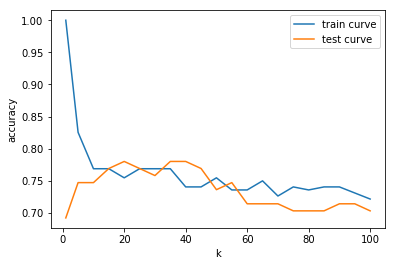

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results['k'], gs_results['train_accuracy'], label='train curve')
plt.plot(gs_results['k'], gs_results['test_accuracy'], label='test curve')
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

### Average several runs = Cross Validation
There is no clear pattern for k between 20 and 40 in the results from above. Let's see if we can get more stable results by averaging the scores over 30 runs

As a small experiment, we can compare the results without standardization by adding scaler=None to the knn_pipe.set_params() call in the for loop

The optimal k is now around 20 with an accuracy of 66 ± 4%.

Let's test with StandardScaler()

In [30]:
# Run several times the evaluation
gs_results = []
for run_idx in range(30):
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.3, random_state=run_idx)

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append({
            'k': k,
            'run_idx': run_idx,
            'train_accuracy': knn_pipe.score(X_tr, y_tr),
            'test_accuracy': knn_pipe.score(X_te, y_te)
        })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

In [31]:
# Group results by alpha value
grouped = gs_results.groupby('k')

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.test_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.test_accuracy.std()

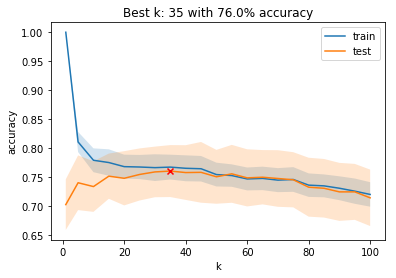

In [32]:
# Plot mean scores
plt.plot(k_values, mean_tr, label='train')
plt.plot(k_values, mean_te, label='test')

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker='x', c='red', zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te-std_te, mean_te+std_te, alpha=0.2)
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*mean_te[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

### Classification report
Above, we decided to tune our k-NN estimator based on the accuracy metric. But, let's take a look at the other classification metrics that we saw in the last unit.



In [37]:
from sklearn.metrics import classification_report

# Tuned k-NN estimator
tuned_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])
tuned_knn.fit(X_tr, y_tr)

# Classification report
y_te_preds = tuned_knn.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_preds))

              precision    recall  f1-score   support

     absence       0.59      0.90      0.71        41
    presence       0.86      0.48      0.62        50

   micro avg       0.67      0.67      0.67        91
   macro avg       0.72      0.69      0.66        91
weighted avg       0.74      0.67      0.66        91



As we can see, the recall value (i.e. "How many times do we predict positive when it is?") is around 0.44 which is not really good for our use case: our k-NN estimator only detected 48% of sick patients. In a medical application, a doctor might want to detect most of the patients that have the disease, at the cost of increasing the missclassification rate for healthy patients which is not an issue if further tests can be performed for those patients.

So, how can we achieve this? At the moment, our k-NN estimator retrieves the k nearest patients, computes the proportion of patients in each class within the neighborhood and predicts the most frequent class. We can retrieve those proportions with the predict_proba() function of the estimator

In [38]:
# Compute probabilities
y_te_probs = tuned_knn.predict_proba(X_te)
print('Predictions:', y_te_preds[:5]) # ['absence' 'presence' 'presence' 'absence' 'presence']
print('Probs:')
print(y_te_probs[:5])

Predictions: ['absence' 'presence' 'presence' 'absence' 'presence']
Probs:
[[0.8        0.2       ]
 [0.14285714 0.85714286]
 [0.25714286 0.74285714]
 [0.74285714 0.25714286]
 [0.22857143 0.77142857]]


For instance, 80% of the k=35 nearest patients to the first test one are labeled as healthy (first column) and the remaining 20% as sick (second column), so the patient is labeled with absence. In other words, our estimator labels patients as sick when the probability in the second column is more than 50%.

Let's see how we can increase recall by adjusting this threshold!

### ROC curve

We discussed above the idea of adjusting our detection threshold to increase the number of times we detect sick patients at the cost of misclassifying healthy patients. A way to analyze the relation between those two quantities is by plotting the **Receiver operating characteristic (ROC) curve.**

To compute it, we can use the roc_curve() function from Scikit-learn

In [39]:
from sklearn.metrics import roc_curve

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_te, y_score=y_te_probs[:, 1], pos_label='presence')

In this code, we pass the true values y_te and y_te_probs[:, 1] which contains the probabilities for the disease category.

The function returns three arrays

- The False Positive Rate (FPR) - how many times we missclassify healthy patients
- The True Positive Rate (TPR) or Recall - how many times we correctly classify sick patients
- The associated threshold values

In [40]:
pd.DataFrame({
    'fpr': fpr,
    'tpr (recall)': tpr,
    'thresholds': thresholds
})

,fpr,tpr (recall),thresholds
0,0.000000,0.00,1.942857
1,0.000000,0.02,0.942857
2,0.000000,0.06,0.885714
3,0.024390,0.12,0.857143
4,0.024390,0.18,0.828571
5,0.048780,0.20,0.771429
6,0.048780,0.26,0.742857
7,0.048780,0.28,0.685714
8,0.073171,0.32,0.657143
9,0.073171,0.36,0.571429


Each row tells us how small the threshold should be to get at least the associated recall value. For instance, with a threshold smaller than 51.4% (row 11), we should get at least 48% recall. And with a threshold smaller than 45.7% (row 12), we should get at least 60% recall. This corresponds to what we saw above with our k-NN classifier: by using the default threshold of 50%, we get the recall score of 48%.

Another way to visualize this table is by plotting the false/true positive rates together

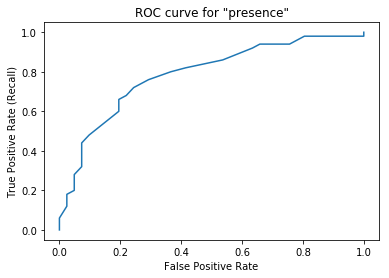

In [41]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC curve for "presence"')
plt.show()

Ideally, we would like to have a **curve close to the upper left corner of the plot** with a high recall and a small false positive rate. A way to quantify how close our curve is to that ideal one is to compute the "area" under our ROC curve (AUC)

In [42]:
from sklearn.metrics import roc_auc_score

# Area under the curve (AUC)
roc_auc_score(y_true=y_te, y_score=y_te_probs[:, 1])

0.7858536585365854

Let's get back to the table and see how we can adapt the threshold to achieve a recall score of 90%. By looking at the second column, we see that the first recall score above 90% is row 21: by setting the threshold to 20%, we should get a recall of 92% - let's verify this with code!

In [43]:
# Adjust threshold
custom_preds = ['absence' if p else 'presence' for p in (y_te_probs[:, 1] < 0.2)]

print(classification_report(y_true=y_te, y_pred=custom_preds))

              precision    recall  f1-score   support

     absence       0.79      0.37      0.50        41
    presence       0.64      0.92      0.75        50

   micro avg       0.67      0.67      0.67        91
   macro avg       0.71      0.64      0.63        91
weighted avg       0.71      0.67      0.64        91



**In this code, we make predictions based on this new probability threshold and print the classification report. As we can see, the recall value when the positive class is presence is now 92% with a precision (i.e. How many times are we correct when we predict presence) of 64%.**

### Summary

In this unit, we discussed when to apply standardization and experimented with KNeighborsClassifier from Scikit-learn. In practice, k-NN is a good baseline which usually returns reasonable results. So it's often a good idea to start by evaluating the most-frequent and k-NN baselines first.

In the next exercise, we will experiment with the famous **MNIST handwritten digits** classification task and evaluate the k-NN baseline. However, to achieve this, we first need to learn two things

* How to transform an image into a set of features
- How to work with larger data sets


We will discuss each point in the next two units.